# DISTPROF Exploratory Data Analysis

## Set Up

### Loading in the data

The load_distprof_data and load_district_type functions first sets the parent directory as the working directory, then uses relative paths to load in the data for each year in the input. The function returns a dictionary with key-value pairs, where the key is the year, and the value is a pandas dataframe. 

In [128]:
import pandas as pd
import numpy as np
import os

os.chdir("/Users/biancaschutz/HERC_Sp25")

def load_distprof_data(years):
    """
    Function saves DISTPROF dataset to a dictionary where the keys are the year and the values are Pandas dataframes with the DISTPROF data for that particular year. 

    Inputs: 
    - years: a list containing YYYY integers representing years.

    Returns:
    - a dictionary where the keys are the year, and the values are dataframes representing the DISTPROF dataset
    """
    distprof_dict = {} # initialize empty dictionary

    for year in years: # for each year

        path = f"{os.getcwd()}/0_Datasets_csv/Data{year}/District/clean_data/distprof_{year}_clean.csv" # pathname dependent on the year

        df = pd.read_csv(path) # read in the csv file

        distprof_dict[year] = df # assign it to the dictionary with its year as a key

        print(f"Loaded in DISTPROF for {year}")
    return distprof_dict

distprof_data = load_distprof_data([2020, 2021, 2022, 2023])

Loaded in DISTPROF for 2020
Loaded in DISTPROF for 2021
Loaded in DISTPROF for 2022
Loaded in DISTPROF for 2023


In [129]:
def load_district_type(years):
    """
    Function saves DISTPROF dataset to a dictionary where the keys are the year and the values are Pandas dataframes with the DISTPROF data for that particular year. 

    Inputs: 
    - years: a list containing YYYY integers representing years.

    Returns:
    - a dictionary with years as the keys and the values are dataframes
    """
    dist_type_dict = {} # initialize empty dictionary

    for year in years: # for each year
        path = f"{os.getcwd()}/0_Datasets_csv/Data{year}/District/clean_data/district_type{year}_clean.csv" # year-dependent path

        df = pd.read_csv(path) # load in csv file

        dist_type_dict[year] = df # assign it to the dictionary with its year as the key

        print(f"Loaded in District Type for {year}")

    return dist_type_dict

dist_type_data = load_district_type([2020, 2021, 2022, 2023])

Loaded in District Type for 2020
Loaded in District Type for 2021
Loaded in District Type for 2022
Loaded in District Type for 2023


In [130]:
def combine_distprof_type(district_type_dict, distprof_dict):
    """
    Function that combines district type and DISTPROF datasets based on year and district ID.

    Inputs:
    - district_type_dict: a dictionary where each key-value pair is a year (YYYY) and a dataframe containing district type data for that year
    - distprof_dict: a dictionary where each key-value pair is a year (YYYY) and a dataframe containing DISTPROF data for that year

    Returns:
    - a dictionary of key-value pairs where the keys are the year of the data, and the values are a joined dataframe of DISTPROF and district type
    """
    if len(district_type_dict) != len(distprof_dict):
        raise("District Type and DISTPROF Data Dictionary Lengths Must Match") # prevent mismatches in length
    
    joined_dict = {} # initialize empty dictionary

    for year in distprof_dict.keys(): # for each year in distprof, join with district type

        print(f"Joining DISTPROF and District Type datasets for {year}")

        # convert the district type columns to integer and remove any non-numeric characters in the string, as necessary
        district_type_dict[year]['District Number'] = district_type_dict[year]['District Number'].astype(str).str.replace("[^0-9]"," ", regex = True).astype(int)

        distprof_dict[year]['DISTRICT'] = distprof_dict[year]['DISTRICT'].astype(str).str.replace("[^0-9]"," ", regex = True).astype(int)

        # prevent problems with any NAs in the district ID columns
        if sum(distprof_dict[year]['DISTRICT'].isna()) != 0 and sum(district_type_dict[year]['District Number'].isna()) != 0:
            raise("NAs in identification columns. Ensure all rows have an ID.")
        
        # join the dataframes together
        joined_df = distprof_dict[year].merge(district_type_dict[year], left_on = ['DISTRICT','DISTNAME'], right_on = ['District Number', 'District'], how = 'inner')
        
        # assign it to a new dictionary with key = year
        joined_dict[year] = joined_df

    return joined_dict
 
joined_by_year = combine_distprof_type(dist_type_data, distprof_data)



Joining DISTPROF and District Type datasets for 2020
Joining DISTPROF and District Type datasets for 2021
Joining DISTPROF and District Type datasets for 2022
Joining DISTPROF and District Type datasets for 2023


### Select Relevant Columns

In [ ]:
def year_dependent_colnames_generator(year, base_names):
    """
    Helper function that creates a list of column names based on the year inputted. 
    Some columns in the data have "District 2020" in the column names, so this helps select for each year the columns necessary.

    Inputs:
    - year: a 4 digit integer representing a year (YYYY), such as 2020
    - base_names: the base names of the columns, excluding "District YYYY", such as "Student Membership: All Students Count"

    Returns:
    - a list of strings representing column names that should exist in a joined District Type and DISTPROF dataframe, depending on input year
    """
    # names that are not dependent on year
    new_names = ['District Number', 'District', 'TEA Description', 'NCES Description']

    for col in base_names: # create new names for year-dependent columns
        new_name = f"District {year} {col}" # new name for column with District YYYY

        new_names.append(new_name)
        
    return new_names


In [132]:
def select_columns(dist_prof_type_dict):
    """
    Function that selects the identifiers for distircts and the features specified as most important by our sponsor, 
    such as racial/ethnic percentages and the count of students. 

    Inputs:
    - a dictionary where the keys are years (YYYY) and the values are dataframes which contain joined DISTPROF and District Type data

    Returns:
    - a dictionary where each dataframe is subsetted to only include the columns specified by our sponsor
    """
    selected_col_dict = {} # initialize empty dictionary

    for year in dist_prof_type_dict.keys():

        # columns of interest
        year_dep_cols = ['Student Membership: White Percent', 'Student Membership: Hispanic Percent', 
                        'Student Membership: African American Percent', 'Student Membership: American Indian Percent',
                        'Student Membership: Asian Percent', 'Student Membership: Pacific Islander Percent',
                        'Student Membership: Two or More Races Percent', 'Student Membership: Econ Disadv Percent',
                        'Student Membership: Special Ed Percent', 'Student Membership: Bilingual/ESL Percent',
                        'Student Membership: Gifted & Talented Percent', 'Student Membership: Immigrant Percent',
                        'Student Membership: All Students Count']
        
        colnames = year_dependent_colnames_generator(year, year_dep_cols) # use helper function

        selected_col_dict[year] = dist_prof_type_dict[year][colnames] # select columns of interest and assign to new dictionary
        
    return selected_col_dict

filtered_data = select_columns(joined_by_year)

In [ ]:
def filter_out_charters(data_dict):
    """
    Takes a joined DISTPROF and District Type dataset and returns only non-charter school district data. 

    Inputs:
    - a dictionary where the keys are years (YYYY) and the values are dataframes which contain joined DISTPROF and District Type data.

    Returns:
    - a dictionary where each dataframe is subsetted to only include non-charter districts. 
    """
    no_charters = {}
    for year in data_dict.keys():
       no_charters[year] = data_dict[year][
    (data_dict[year]['TEA Description'] != 'Charter School Districts') & 
    (data_dict[year]['TEA Description'] != 'Charter Schools')]
    return no_charters

no_charter_data = filter_out_charters(filtered_data)

# t-SNE

Via DataCamp: t-SNE (t-distributed Stochastic Neighbor Embedding) is an unsupervised non-linear dimensionality reduction technique for data exploration and visualizing high-dimensional data. Non-linear dimensionality reduction means that the algorithm allows us to separate data that cannot be separated by a straight line.

In [165]:
from sklearn.manifold import TSNE
import plotly.express as px
import re

def run_tsne(year, components, data_dict, column1, column2, y_var = 'TEA Description'):
    """
    Runs t-SNE based on two specified columns, to visualize the relationship between the two. 

    Inputs:
    - year: a 4 digit integer representing a year, YYYY, such as 2020
    - components: the number of components you want t-SNE to use
    - data_dict: a dictionary with key-value pairs where the key is a year, and the value is a DISTPROF dataset as a dataframe
    - column1: a string representing the first demographic you want plotted
    - column2: a string representing the second demographic you want plotted
    - y_var: a string representing a column that you want to classify the data with. Default is TEA Description
    """
    X = data_dict[year][[f"District {year} {column1}", f"District {year} {column2}"]]

    y = data_dict[year][y_var]

    label = re.sub(f"District {year}", "", y_var)

    tsne = TSNE(n_components=components, random_state=42)

    X_tsne = tsne.fit_transform(X)

    tsne.kl_divergence_

    fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color = y)
    fig.update_layout(
    title=f"t-SNE visualization of DISTPROF by {label}, {year}",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
    legend_title=label
    )
    fig.show()


In [166]:
# Example use of t-SNE with all numeric/student population columns
run_tsne(2020, 2, no_charter_data, column1 = "Student Membership: Hispanic Percent", column2 = "Student Membership: Econ Disadv Percent")

# Based on using TEA Description alone, there appears to be no clear clustering pattern with district type, 
# though there are some clusters here and there (but include districts of all kinds)

In [167]:
# Use custom y-variable - for example, Hispanic percent

run_tsne(2020, 
         2, 
         no_charter_data, 
         column1 = "Student Membership: Hispanic Percent", column2 = "Student Membership: Econ Disadv Percent", 
       y_var = 'District 2020 Student Membership: White Percent')

# Exploratory Data Analysis

## Distribution of Variables

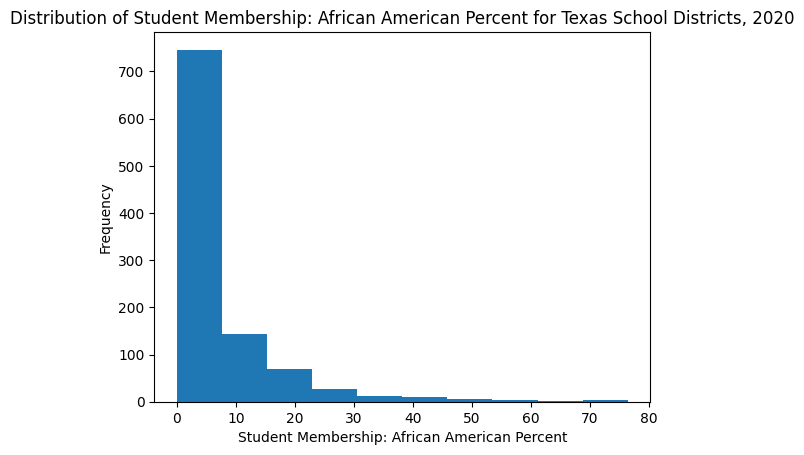

In [168]:
import matplotlib.pyplot as plt

def generate_demographic_histogram(year, variable, data_dict):
    """
    Function that creates a single histogram for a particular year of DISTPROF data. 
    """
    col = data_dict[year][f"District {year} {variable}"]
    plt.hist(col)
    plt.title(f"Distribution of {variable} for Texas School Districts, {year}")
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.show()

generate_demographic_histogram(2020, "Student Membership: African American Percent", no_charter_data)

# Barplots to Visualize Top N School Districts for a Particular Demographic

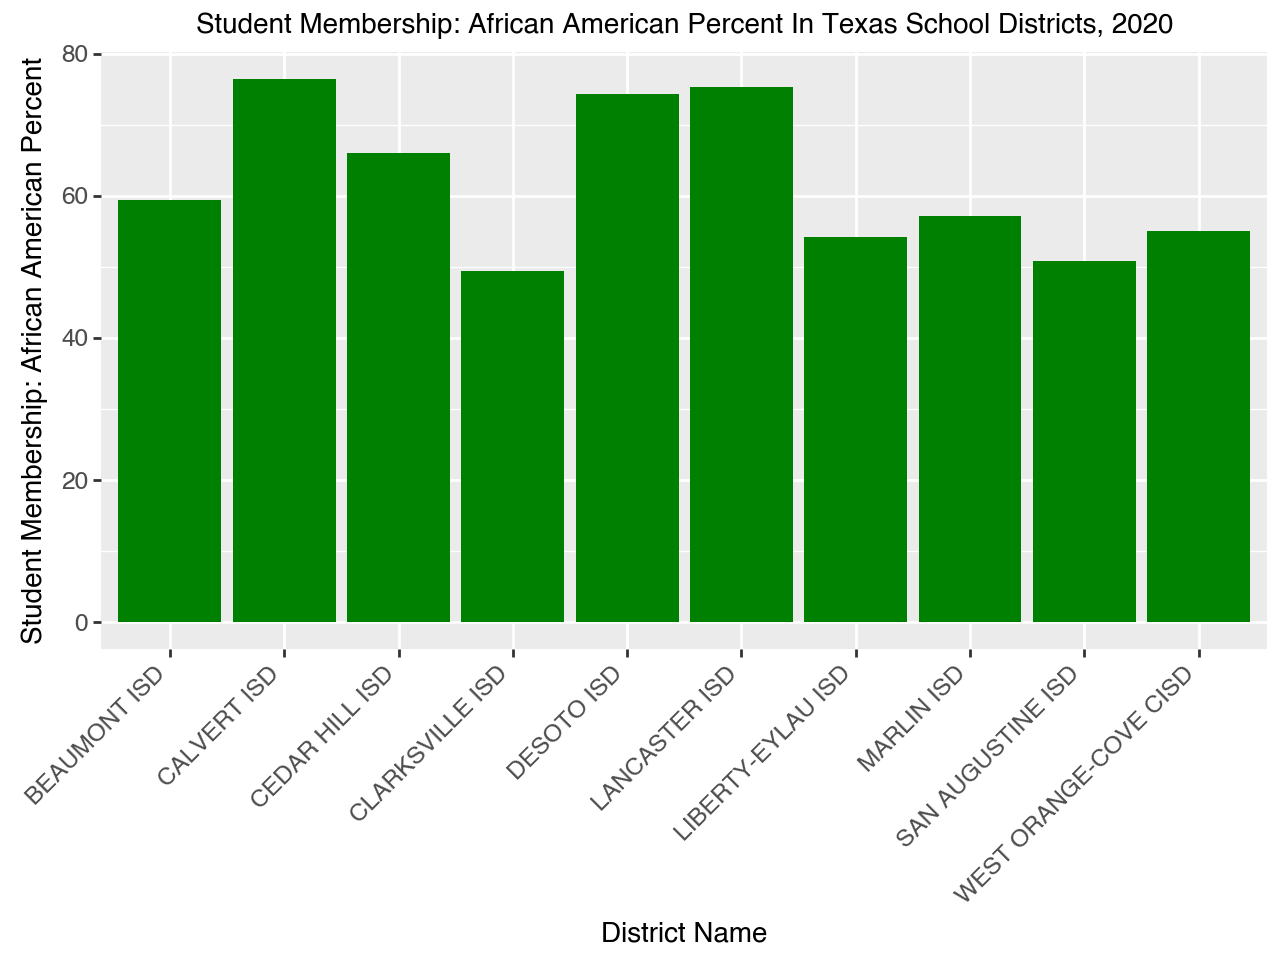

In [169]:
from plotnine import geom_col, ggplot, aes, scale_x_discrete, labs, theme, element_text

def generate_demographic_barplot(year, variable, data_dict, n_districts = 10):
    """
    Function that generates a barplot showing the top N school districts for a specified demographic in a particular year. 

    Inputs:
    - year: a 4 digit integer representing a year, YYYY, such as 2020
    - variable: a string representing the demographic you want plotted
    - data_dict: a dictionary with key-value pairs where the key is a year, and the value is a DISTPROF dataset as a dataframe
    - n_districts: an integer representing the number of districts you want plotted. Default value is 10. 
    """
    data = data_dict[year][[f"District {year} {variable}", "District"]].sort_values(by = f"District {year} {variable}", ascending = False).head(n_districts)
    plot = (ggplot(data) + 
            aes(x = "District", y = f"District {year} {variable}") + 
            geom_col(fill = "green") + 
            theme(legend_position = 'none') + 
            labs(title = f"{variable} In Texas School Districts, {year}",
                 x = "District Name",
                 y = variable) + 
            theme(axis_text_x = element_text(angle = 45, hjust = 1),
                  title = element_text(size = 10)))
    return(plot)

generate_demographic_barplot(2020, "Student Membership: African American Percent", no_charter_data)
